## Solving for the beam

This notebook is an example showing how to use the beam_solver package to construct or estimate the primary beam given a catalog of sources. 

In [5]:
%matplotlib notebook
from beam_solver.data import DATA_PATH
import beam_solver.catdata as cd
import beam_solver.beamsolve as bs
import beam_solver.beam_utils as bt
import beam_solver.fits_utils as ft
import nose.tools as nt
import numpy as np
import aipy
import os
import copy
import pylab
from collections import OrderedDict
import time
import linsolve
import healpy as hp
import numpy as np
import glob

In [6]:
# path where the fitsfiles are stored
filepath = '/Users/Ridhima/Documents/ucb_projects/beam_characterization/new_fitsfiles'
# getting fitsfiles from the directory
fitsfiles = glob.glob(filepath  + '/2458115.*.xx_cut30m_briggs.fits')
fitsfiles.sort()

for fn in fitsfiles:
    fnsplit = fn.split('/')[-1].split('.')
    jd = fnsplit[0] + '.' + fnsplit[1]
    jd = float(jd) + 5/24./60.
    ft.add_keyword(fn, 'JD', jd, fn, overwrite=True)

In [8]:
ras = [30.01713089, 74.03785836567484]
decs = [-30.88211818, -30.08651872619927]

catd = cd.catData()
catd.gen_catalog(ras, decs, fitsfiles_xx=fitsfiles)

/Users/Ridhima/software/anaconda2/lib/python2.7/site-packages/beam_solver-0.1.0-py2.7.egg/beam_solver/extract.py:57: Warning: WARNING: Right ascension or declination outside image field, therefore values are set to nan
  warnings.warn('WARNING: Right ascension or declination outside image field, therefore values are set to nan', Warning)


In [20]:
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam = bt.get_fitsbeam(beamfits, 151e6)
modfluxvals = catd.calc_catalog_flux(beam, 'xx')

In [30]:
bms = bs.BeamOnly(cat=catd, bm_pix=61)
bms.add_eqs(catalog_flux=modfluxvals)
sol = bms.solve()
obsbeam = bms.eval_sol(sol)

Solving 0/1


<IPython.core.display.Javascript object>


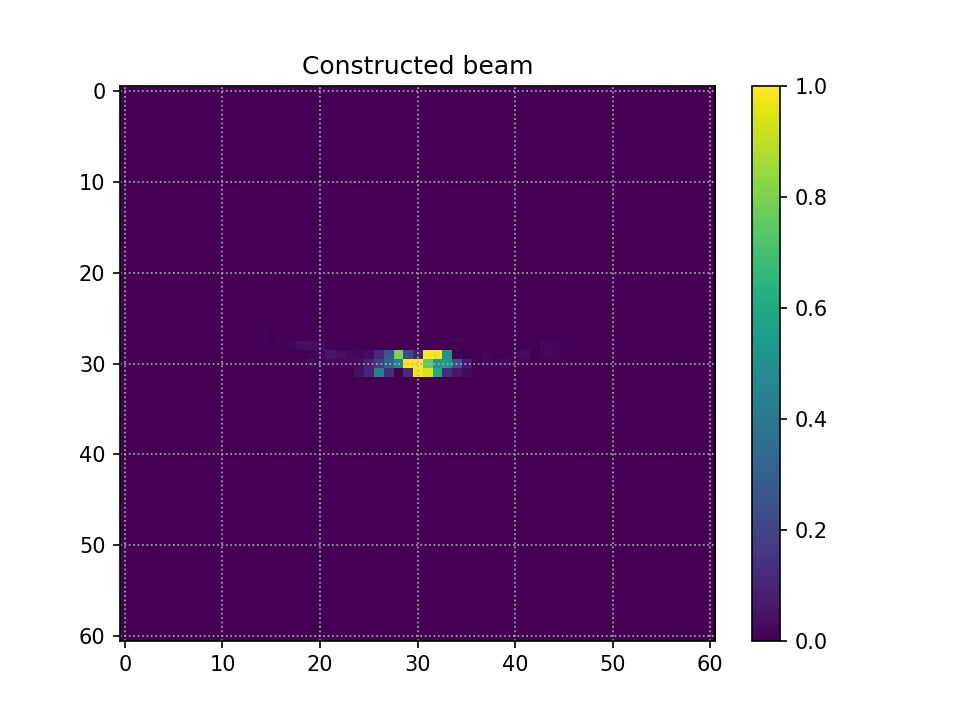

In [31]:
fig = pylab.figure()
pylab.title('Constructed beam')
pylab.imshow(obsbeam.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
pylab.colorbar()
pylab.grid(ls='dotted')

## Using cross-poalrizations 

Assuming that the beam in both polarization direction (i.e aalong x and y axis) is a 90 degree rotation of each other we use this property to solve for the beam.

In [25]:
catdp = cd.catData()
catdp.gen_catalog(ras, decs, fitsfiles_xx=fitsfiles, fitsfiles_yy=fitsfiles, pols=['xx', 'yy'])

In [26]:
bms = bs.BeamOnlyCross(cat=catdp, bm_pix=61)
bms.add_eqs(catalog_flux_xx=modfluxvals, catalog_flux_yy=modfluxvals)
sol = bms.solve()
obsbeam = bms.eval_sol(sol)

Solving 0/1


<IPython.core.display.Javascript object>


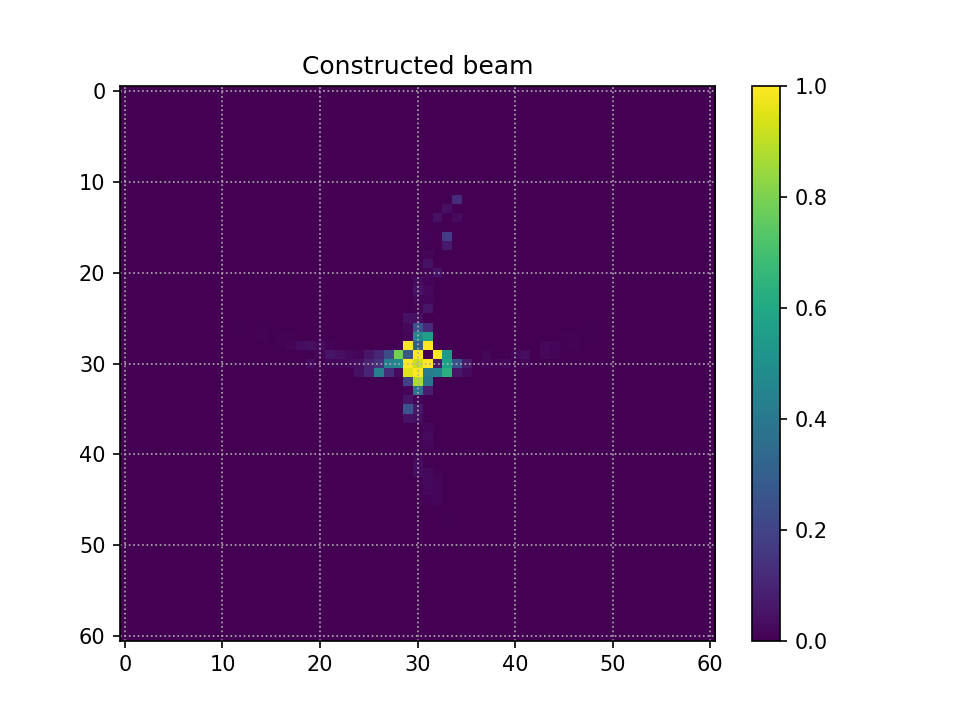

In [28]:
fig = pylab.figure()
pylab.title('Constructed beam')
pylab.imshow(obsbeam.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
pylab.colorbar()
pylab.grid(ls='dotted')